# 村田安雄『動的経済システムの最適制御』第4章のシミュレーション

(Version: 0.0.1)

「第4章 ライフサイクル理論による消費経路」について本にシミュレーション結果があるが、それを「追試」してみる。

追試の他に scipy.optimize.minimize を使って力技で最適化してみた結果も見てみる。

In [1]:
%matplotlib inline

In [2]:
from time import gmtime, strftime
print("Time-stamp: <%s>" % strftime("%Y-%m-%dT%H:%M:%SZ", gmtime()))

Time-stamp: <2022-05-12T15:22:42Z>


In [3]:
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np

パラメータを本から書き写す。$\sigma^2$ は p.74 から。

In [4]:
R = 65
sigma_sq = 0.1625567

p.76 より、基準型(standard)、代替型(alternative)、ケースI、ケースII。

In [5]:
case_I = {
    'T': 85,
    'p': 0.00652
}

case_II = {
    'T': 90,
    'p': 0.00838
}

standard = {
    'gamma': 3,
    'r': 0.04,
    'theta': 0.01,
    'tau': 0.3,
    'k': 0.5,
    'A22': 200,
    'z': 100,
    'F65': 0
}

alternative = {
    'gamma': 4,
    'r': 0.05,
    'theta': 0.02,
    'tau': 0.2,
    'k': 50,
    'A22': 400,
    'z': 70,
    'F65': 1000
}

p.75 より、年齢別平均所得。

In [6]:
y = [0] * 22 + [
    154.7, # 22
    162.0, # 23
    168.4, # 24
    175.0, # 25
    182.4, # 26
    191.9, # 27
    201.0, # 28
    209.0, # 29
    217.3, # 30
    226.2, # 31
    235.4, # 32

    243.1, # 33
    251.0, # 34
    258.2, # 35
    267.1, # 36
    275.7, # 37
    284.0, # 38
    291.2, # 39
    298.9, # 40
    304.4, # 41
    310.5, # 42
    316.0, # 43

    319.7, # 44
    322.4, # 45
    325.4, # 46
    328.1, # 47
    326.6, # 48
    325.1, # 49
    323.8, # 50
    322.2, # 51
    321.7, # 52
    315.8, # 53
    308.4, # 54
    
    301.1, # 55
    292.1, # 56
    281.0, # 57
    267.0, # 58
    254.0, # 59
    243.5, # 60
    234.8, # 61
    228.5, # 62
    221.0, # 63
    214.9, # 64
    210.0, # 65
]

y_R_orig = y[R]

パラメータはグローバル変数に代入して使う。

In [7]:
def reset_to_standard ():
    GL = globals()
    for n, v in standard.items():
        GL[n] = v
    for n, v in case_I.items():
        GL[n] = v

def set_case_II ():
    GL = globals()
    for n, v in case_II.items():
        GL[n] = v

def set_alternative (*args):
    GL = globals()
    for n in args:
        GL[n] = alternative[n]

パラメータの変更後、常に次の処理をしなければならない。

In [8]:
def set_params ():
    GL = globals()
    GL['rho'] = 1 + r
    GL['alpha'] = (1 + theta) ** -1
    y[R] = y_R_orig + F65

まずは基準型にセットしておく。

In [9]:
reset_to_standard()
set_params()

$C_t$ と $A_t$ を求める方法だが、まず $A_{T+1}$ がわかっているところから $C_T$ を求め、そこから $A_T$ が求まる。次いで $t \ge R + 1$ の間は $A_{t+1}$ と $C_{t+1}$ から $C_t$ と $A_t$ が求まる。そして $C_R$ と $A_R$ が特別に求まった後、今度は逆に $A_{22}$ からはじめてそこから $C_{22}$ が求まり、$t \le R -1$ の間は、$C_t$ と $A_t$ から $C_{t+1}$ と $A_{t+1}$ が求まることになる。問題はパラメータとして $A_{22}$ は与えられるが、$A_{T+1}$ は与えられないという点である。おそらくこの本の著者の手元にはそれを解析的に求める方法があったものと思われる。しかし、私にはその方法がわからない。

そこで scipy.optimize.root を使って適当な $A_{T+1}$ を求めるという方針にする。上の方法でやると、$A_{T+1}$ と $A_{22}$ からは $A_R$ において二通りの値が得られる。その差が 0 となるような $A_{T+1}$ を求めるのだ。

そこで $A_{T+1}$ が与えられたときの $C_t$ と $A_t$ の列および $A_R$ の二つの値の差を出力する関数をまず定義する。それが以下になる。

In [10]:
def get_Cts_Ats (A_Tp1):
    try:
        A_Tp1 = A_Tp1[0]
    except:
        pass
    Ats = [A_Tp1]
    Cts = []
    A_tp1 = A_Tp1
    # 式(25)
    C_T = ((rho * alpha * k * (((1 + p) ** (T - R)) -1)) ** (-1/gamma)) * A_Tp1
    # 式(2')
    A_T = (rho ** -1) * A_Tp1 + C_T - z
    Ats.append(A_T)
    Cts.append(C_T)
    C_tp1 = C_T
    A_tp1 = A_T
    t = T - 1
    while t >= R + 1:
        # 式(25) と 式(26) の間の式
        C_t = ((
            ((1 + p) ** (R - t - 1)) * (C_tp1 ** - gamma)
            + (((1 + p) ** (t - R)) - 1) * k * (A_tp1 ** - gamma)
        ) * rho * alpha) ** (- 1/gamma)
        # 式(2')
        A_t = (rho ** -1) * A_tp1 + C_t - z
        Ats.append(A_t)
        Cts.append(C_t)
        C_tp1 = C_t
        A_tp1 = A_t
        t = t - 1
    assert t == R
    A_Rp1 = A_tp1
    # 式(27') の下の式
    C_R = (rho * alpha * ((1 + p) ** -1) * (C_tp1 ** - gamma)) ** (-1/gamma)
    # 式(1')
    A_R = (rho ** -1) * A_tp1 + C_R - (1 - tau) * y[R]
    Ats.append(A_R)
    Cts.append(C_R)
    rAts = list(reversed(Ats))
    rCts = list(reversed(Cts))
    Ats = []
    Cts = []
    t = 22
    A_t = A22
    while t <= R - 1:
        # 式(36)
        L_t = A_t \
            + (1 - tau) * sum([y[t + i] * (rho ** - i)
                               for i in range(R - t + 1)]) \
            - A_Rp1 * (rho ** (t - R - 1))
        # 式(34)
        g = ((rho ** (1 - gamma)) * alpha) ** (1/gamma)
        # 式(33)
        G_tp1 = (1 - g ** (R - (t + 1) + 1)) / (1 - g)
        # 式(40)
        C_t = L_t / (1 + ((rho ** (1 - gamma)) * alpha * (G_tp1 ** gamma)
                          * (1 + (1/2) * gamma * (gamma + 1) * sigma_sq))
                     ** (1/gamma))
        Ats.append(A_t)
        Cts.append(C_t)
        # 式(1)
        A_t = (A_t + (1 - tau) * y[t] - C_t) * rho
        t = t + 1
    d65 = A_R - A_t
    return Cts + rCts, Ats + rAts, d65


ところでこの関数がまともに動くまでデバッグするには苦労した。もちろん私が産んだケアレスミスもあったが、本にも誤植があった。

一つは式(40)において、大カッコ「[」が 1 + の後、$\rho^{1-\gamma}$ の前に抜けていたこと。まぁ、これは大したことない。

もう一つは式(34) いおいて、$\gamma$ であるべきところが $r$ に置き換わっていたこと。ありがちな誤植だが、これで結果がかなり変わっていた。

さてここで root finding を実際してみよう。

In [11]:
def score_A_Tp1 (A_Tp1):
    Cts, Ats, d65 = get_Cts_Ats(A_Tp1)
    return d65

sol = scipy.optimize.root(score_A_Tp1, A22)
print(sol)

    fjac: array([[-1.]])
     fun: 0.0
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.28611646e-08])
       r: array([-4.16830972])
  status: 1
 success: True
       x: array([141.19293571])


ちゃんと求まったようだ。p.78 の数値の $A_{T+1}$ は 141 なのであってる感じである。一応、$C_t$ と $A_t$ の列も見ておこう。

In [12]:
Cts, Ats, d65 = get_Cts_Ats(sol.x)
Cts

[98.89900967794428,
 100.69493964819019,
 102.53354804923585,
 104.41654353366958,
 106.34575419676544,
 108.32313985635952,
 110.3508059803368,
 112.43101953503451,
 114.5662270822446,
 116.75907551958784,
 119.01243594227093,
 121.32943120813461,
 123.71346791838484,
 126.16827369138393,
 128.69794081694565,
 131.30697764805112,
 134.00036943535014,
 136.78365076419914,
 139.66299235190638,
 142.64530575731246,
 145.7383706214355,
 148.95099050601226,
 152.2931853866476,
 155.77643162762524,
 159.41396417740802,
 163.22116133402164,
 167.21604061235485,
 171.41990640481876,
 175.85820857044618,
 180.56169970918344,
 185.56802444232883,
 190.92394866855255,
 196.68856311050806,
 202.93801743198352,
 209.77274833191484,
 217.32895043511553,
 225.797647710427,
 235.458267435292,
 246.74216254596735,
 260.3646376020246,
 277.63691837725446,
 301.3554943032281,
 339.25339016259835,
 429.8419708277387,
 433.11710709602147,
 435.4733156820883,
 436.89553326990807,
 437.3747517149408,
 436.9

In [13]:
Ats

[200,
 217.76662993493792,
 239.69055789821763,
 265.2384902429411,
 294.6548245776424,
 328.62863319611205,
 368.82091307334264,
 415.13691137672606,
 466.9661275153592,
 524.6902964504392,
 588.9220697680854,
 660.077219178847,
 737.274499489541,
 820.8314728340024,
 910.4193271083233,
 1007.4390417430327,
 1111.886946658781,
 1223.754040312368,
 1342.4428051300956,
 1468.490205289317,
 1600.4818955132846,
 1738.9772658875231,
 1883.6753263967714,
 2033.379026650529,
 2187.41389882382,
 2346.011132032268,
 2508.9583695261763,
 2673.1768220703743,
 2838.499992292178,
 3004.873855070601,
 3171.8462415758745,
 3339.926945818888,
 3504.865517036349,
 3665.019232082875,
 3819.7652632369272,
 3967.0410155012128,
 4104.268547668741,
 4227.985735956647,
 4337.140567262209,
 4431.282340904891,
 4508.68881143498,
 4566.641968780035,
 4596.78593345588,
 4584.281045025013,
 4473.496637165165,
 4305.99471127191,
 4129.342251413415,
 3944.1445868692476,
 3751.0406285604795,
 3550.6977969054606,
 3

In [14]:
d65

0.0

ここで得られた Cts Ats に名前を付けておく。

In [15]:
Ats0 = Ats
Cts0 = Cts

さてここからは複雑な式を解析的に求めるのではなく、力技で最適化したら、同じ結果が出るのかというのを調べてみたい。そのために必要な定義を書き写していく。$C_t$ の値を求めれば $A_t$ の値は簡単に出るので、$C_t$ の値をいろいろな方法で出してそれが上の Cts0 と等しいか見ていく。

Cts のベクトルの正しさは差の二乗和によってみるのでそれ用の関数 ssd を定義しておく。

In [16]:
def ssd (a, b): # Sum of Squared Difference
    a = np.array(a)
    b = np.array(b)
    return np.sum((a - b) ** 2)

基本的な定義・式を書き写す。

In [17]:
# 式(21)
def U (C):
    return ((1 - gamma) ** -1) * (C ** (1 - gamma))

# 式(22)
def W (A):
    return k * ((1 - gamma) ** -1) * (A ** (1 - gamma))

# 式(23)
def P (t):
    if t < R:
        return 0
    #assert t <= T
    return 1 - ((1 + p) ** (R - t))

# 式(3)の前の式。
def Phi(t1, t2):
    assert t2 >= t1
    return np.prod([(1 - P(t)) for t in range(t1, t2 + 1)])

# 式(3)
def score_Et_UT (t, Cts, Ats):
    s = 0
    for i in range(T - t + 1):
        Pti = P(t + i)
        s += Phi(t, t + i) * (U(Cts[t + i - 22])
                                + ((Pti / (1 - Pti)) * W(Ats[t + 1 + i - 22])
                                   * alpha)) * (alpha ** i)
    return s

Cts が決まっているなら Ats は簡単に求まる。

In [18]:
def get_Ats (Cts):
    Ats = [A22]
    A_t = A22
    t = 22
    while t <= R:
        # 式(1)
        A_tp1 = (A_t + (1 - tau) * y[t] - Cts[t - 22]) * rho
        A_t = A_tp1
        Ats.append(A_t)
        t = t + 1
    while t <= T:
        # 式(2)
        A_tp1 = (A_t + z - Cts[t - 22]) * rho
        A_t = A_tp1
        Ats.append(A_t)
        t = t + 1
    return Ats

いちおう検算しておく。

In [19]:
Ats = get_Ats(Cts0)
ssd(Ats, Ats0)

2.0363183353009514e-22

最適化は Cts の長い列をまるごと求める形になる。

最適化の途中ときどき、Ats や Cts がマイナスになることがあった。そこでそれらの値が起こらないよう制約を付ける。bounds や constraints を指定して最適化手法は SLSQP を使う。

Ats の制約は次のようにした。

In [20]:
def Ats_cons (Cts):
    Ats = get_Ats(Cts)
    return sum([i for i in Ats if i < 0])

さて、最適化はどういうことに関して行っているのか。実はこの本には「目的関数」がこの章では直接書かれていない。そこでまずは最も簡単な候補として、各 $t$ における効用を純粋に足し合わせたものを考える。それを Cts1 とする。なお、scipy.optimize.minimize は最小化でこれは効用の最大化であるため、スコアをマイナスにする必要があることに注意すること。

In [21]:
def score_simple_sum (Cts):
    Ats = get_Ats(Cts)
    s = 0
    for t in range(22, T+1):
        Pt = P(t)
        # 式(2) の後の式
        s += (1 - Pt) * U(Cts[t - 22]) + Pt * W(Ats[t + 1 - 22]) * alpha
    return -s

res = scipy.optimize.minimize(score_simple_sum, [10] * (T - 22 + 1),
                              bounds=([(0, np.inf)] * (T - 22 + 1)),
                              constraints=(
                                  {'type': 'ineq', 'fun': Ats_cons},
                              ), method="SLSQP")
res

     fun: 0.0013809897179756314
     jac: array([-2.75496859e-07, -2.75496859e-07, -2.75511411e-07, -2.75511411e-07,
       -2.75511411e-07, -2.75511411e-07, -2.75511411e-07, -2.75511411e-07,
       -2.75525963e-07, -2.75525963e-07, -2.75525963e-07, -2.75525963e-07,
       -2.75525963e-07, -2.75525963e-07, -2.75525963e-07, -2.75525963e-07,
       -2.75525963e-07, -2.75525963e-07, -2.75525963e-07, -2.75525963e-07,
       -2.75525963e-07, -2.75525963e-07, -2.75525963e-07, -2.75525963e-07,
       -2.75555067e-07, -2.75555067e-07, -2.75555067e-07, -2.75555067e-07,
       -2.75555067e-07, -2.75584171e-07, -2.75555067e-07, -2.75584171e-07,
       -2.75584171e-07, -2.75584171e-07, -2.75569619e-07, -2.75569619e-07,
       -2.75569619e-07, -2.75569619e-07, -2.75569619e-07, -2.75569619e-07,
       -2.75569619e-07, -2.75569619e-07, -2.75569619e-07, -2.75569619e-07,
       -2.78814696e-07, -2.82088877e-07, -2.85406713e-07, -2.88768206e-07,
       -2.92144250e-07, -2.95578502e-07, -2.99041858e-07, 

In [22]:
Cts1 = res.x
Ats1 = get_Ats(Cts1)
Ats1


[200,
 160.8053980990537,
 125.35740844797785,
 93.15069567670486,
 64.46051099736174,
 40.00991417981419,
 21.497286297887605,
 8.868944894705406,
 1.559460857617471,
 8.77889760886319e-12,
 4.8573305623095875,
 16.60654577293964,
 34.431322350729545,
 58.7202839234401,
 89.22239812508809,
 127.42379277776635,
 173.41403836685106,
 227.28629086094904,
 288.55502890479755,
 357.880116424166,
 433.9822057297278,
 517.5691786669566,
 608.5036288345635,
 705.7690571156942,
 808.8907009164272,
 918.3212120667517,
 1034.0945435266608,
 1153.406809821991,
 1276.399566542625,
 1403.3656350581866,
 1534.2455469109968,
 1669.9966558345516,
 1806.882609732353,
 1943.8568023625744,
 2080.9955632945084,
 2217.0678751792593,
 2350.502280036013,
 2479.0820615640655,
 2603.3410348270254,
 2724.926367449912,
 2845.0415138133385,
 2965.374866388181,
 3085.0615534616763,
 3205.094908442576,
 3326.3623979294543,
 3404.566948302721,
 3486.859392243578,
 3573.3975908534726,
 3664.3447994828853,
 3759.87136

In [23]:
ssd(Cts1, Cts0)

1601336.3862958383

…ということで、Cts0 とはかなり異なる結果が得られた。ただ消費が毎期ほぼ同じなので、これはこれでまともな結果ではないかという気もする。ただ、資産が残り過ぎか。

次に 22歳のときの効用を最大化することを考える。$E_{22}U_{T}$ を最大化してみる。

In [24]:
def score_E22_UT (Cts):
    return -score_Et_UT(22, Cts, get_Ats(Cts))

res = scipy.optimize.minimize(score_E22_UT, [10] * (T - 22 + 1),
                              bounds=([(0, np.inf)] * (T - 22 + 1)),
                              constraints=(
                                  {'type': 'ineq', 'fun': Ats_cons},
                              ), method="SLSQP")
res

     fun: 0.001967401887271909
     jac: array([-2.50758603e-07, -2.55298801e-07, -2.59926310e-07, -2.64641130e-07,
       -2.69414159e-07, -2.74274498e-07, -2.79222149e-07, -2.84257112e-07,
       -2.89379386e-07, -2.94559868e-07, -2.99856765e-07, -3.05240974e-07,
       -3.10712494e-07, -3.16271326e-07, -3.21946573e-07, -3.27680027e-07,
       -3.33529897e-07, -3.39467078e-07, -3.45520675e-07, -3.51661583e-07,
       -3.57918907e-07, -3.64263542e-07, -3.70724592e-07, -3.77302058e-07,
       -3.83966835e-07, -3.90748028e-07, -3.97616532e-07, -4.04630555e-07,
       -4.11760993e-07, -4.18978743e-07, -4.26342012e-07, -4.33792593e-07,
       -4.41388693e-07, -4.49101208e-07, -4.56959242e-07, -4.64904588e-07,
       -4.72995453e-07, -4.81231837e-07, -4.89584636e-07, -4.98082954e-07,
       -5.06697688e-07, -5.15457941e-07, -5.24334610e-07, -5.33356797e-07,
       -5.48636308e-07, -5.70580596e-07, -5.99888153e-07, -6.37548510e-07,
       -6.84754923e-07, -7.43078999e-07, -8.14441592e-07, -

In [25]:
Cts2 = res.x
Ats2 = get_Ats(Cts2)
Ats2

[200,
 155.69926136855824,
 116.46824216174441,
 81.83964352900782,
 52.12817497090654,
 28.098044582464983,
 11.490929155626933,
 2.2977189421364845,
 6.295977073023096e-12,
 5.07766258513791,
 18.248507914246222,
 40.04081658013229,
 69.69349054331937,
 107.65297976618697,
 153.7284977928907,
 209.469030101589,
 275.02904175268526,
 350.57026273314955,
 435.6776958993598,
 531.0855731060245,
 635.591205359829,
 749.9828419659083,
 874.206573405952,
 1007.3329329547408,
 1148.977907839493,
 1299.688333134381,
 1459.5963658581713,
 1626.0005742218054,
 1799.1489740779418,
 1979.4452412335975,
 2166.9453499073734,
 2362.7270329887733,
 2563.1788333516292,
 2767.384426149655,
 2975.555558272401,
 3186.6023274872196,
 3399.100047980198,
 3610.985179547631,
 3822.9500418150956,
 4036.8074540375205,
 4253.932944128928,
 4476.194140778579,
 4702.912701438134,
 4935.2761047413605,
 5174.373401075495,
 5375.797124016678,
 5587.524679049633,
 5810.529787641899,
 6045.773646877881,
 6294.1955959

In [26]:
ssd(Cts2, Cts0)

2639276.870558162

…ということで、これは22歳のときのみの判断なため、高齢になったときの消費を過少評価しているようだ。当然 Cts0 とも大きく違う。

ここでどうすればよいか詰まった。22歳のときだけでないようにすればいいのだから、$E_tU_T$ を $t$ に関して足し合わせればいいのかとも考えた。しかし、それは求めるのが重すぎるだけで、どうも正しい結果とは思えない。一応コメントアウトしてそのコードだけは載せておこう。

In [27]:
# def score_sum_Et_UT (Cts):
#     Ats = get_Ats(Cts)
#     s = 0
#     for t in range(22, T + 1):
#         s += score_Et_UT(t, Cts, Ats)
#     return -s
#
# res = scipy.optimize.minimize(score_sum_Et_UT, [10] * (T - 22 + 1),
#                               bounds=([(0, np.inf)] * (T - 22 + 1)),
#                               constraints=(
#                                   {'type': 'ineq', 'fun': Ats_cons},
#                               ), method="SLSQP")
# res

In [28]:
# Cts3 = res.x
# Ats3 = get_Ats(Cts3)
# Ats3

In [29]:
# ssd(Cts3, Cts0)

本ではベルマン方程式を使っていく。ではそのベルマン方程式にできるだけ忠実にやってみてはどうかと考えた。それが以下になる。

In [30]:
def score_V (Cts):
    Ats = get_Ats(Cts)
    V = 0
    t = T
    while t >= 22:
        V = (1 - P(t)) * U(Cts[t - 22]) + P(t) * W(Ats[t + 1 - 22]) * alpha \
            + (1 - P(t)) * alpha * V
        t = t - 1
    return -V

res = scipy.optimize.minimize(score_V, [10] * (T - 22 + 1),
                              bounds=([(0, np.inf)] * (T - 22 + 1)),
                              constraints=(
                                  {'type': 'ineq', 'fun': Ats_cons},
                              ), method="SLSQP")
res

     fun: 0.0019674143739656
     jac: array([-2.50787707e-07, -2.55327905e-07, -2.59897206e-07, -2.64612027e-07,
       -2.69414159e-07, -2.74274498e-07, -2.79193046e-07, -2.84228008e-07,
       -2.89379386e-07, -2.94588972e-07, -2.99914973e-07, -3.05270078e-07,
       -3.10741598e-07, -3.16300429e-07, -3.21975676e-07, -3.27709131e-07,
       -3.33559001e-07, -3.39496182e-07, -3.45520675e-07, -3.51690687e-07,
       -3.57918907e-07, -3.64234438e-07, -3.70695489e-07, -3.77302058e-07,
       -3.83908628e-07, -3.90718924e-07, -3.97616532e-07, -4.04601451e-07,
       -4.11760993e-07, -4.18978743e-07, -4.26312909e-07, -4.33792593e-07,
       -4.41417797e-07, -4.49072104e-07, -4.56988346e-07, -4.64933692e-07,
       -4.72966349e-07, -4.81231837e-07, -4.89555532e-07, -4.98082954e-07,
       -5.06726792e-07, -5.15487045e-07, -5.24392817e-07, -5.33385901e-07,
       -5.48665412e-07, -5.70580596e-07, -5.99917257e-07, -6.37606718e-07,
       -6.84754923e-07, -7.43049895e-07, -8.14499799e-07, -9.

In [31]:
Cts4 = res.x
Ats4 = get_Ats(Cts4)
Ats4

[200,
 155.69938721225023,
 116.46872797951703,
 81.84022628532688,
 52.1286160201431,
 28.098201447115297,
 11.49079638353835,
 2.2975143572454684,
 -6.11191965163016e-07,
 5.0780394126443005,
 18.24897463992888,
 40.041504903026706,
 69.69459534241008,
 107.65409707718322,
 153.72958094998475,
 209.47015866735964,
 275.03073297687035,
 350.572130683442,
 435.6800317467629,
 531.0881597265151,
 635.5947407214434,
 749.9868943361998,
 874.2106528101615,
 1007.337512164048,
 1148.982860480998,
 1299.6936792548129,
 1459.602255262573,
 1626.0075512614355,
 1799.156768851,
 1979.4538778949661,
 2166.9551771151796,
 2362.7376750017784,
 2563.190510756054,
 2767.3969548728046,
 2975.56880812781,
 3186.616670005345,
 3399.1153240645535,
 3611.0006867348093,
 3822.966860675788,
 4036.825078798515,
 4253.951321995148,
 4476.214083314456,
 4702.9338425598935,
 4935.298568571942,
 5174.397572133276,
 5375.822893218837,
 5587.551221090707,
 5810.558625944081,
 6045.803757505315,
 6294.22647539634

In [32]:
ssd(Cts4, Cts0)

2639282.2591573615

ところがどうもこの CTs4 は Cts2 と同じものらしい。

In [33]:
ssd(Cts4, Cts2)

1.132545479811438e-05

…ということで、ベルマン方程式って何を求めてるのだ？ と考えることになった。$t$ 期ごとに最適化するということでそれは Cts を一気に最適化するのとはまた違うのではないか？ …そう考えるに至った。

逐次に最適化していく…というアイデアを推し進めてみよう。22歳のときには高齢の影響をほぼ無視するが、高齢になれば今の自分から見てさらに高齢になることを無視しなくなるだろう。

そこでまず $E_{22}U_T$ で 22歳のときは $C_{22}$ を判定するが、23歳になればそれはそれで $E_{23}U_T$ から $C_{23}$ を判定すると考えればどうか。以降 $C_{22}$ から $C_{t-1}$ まで決まっている前提で、逐次 $E_tU_T$ から $C_t$ を求めればいいのではないか。

そういう方針でやったのが次のものである。これは時間がかかる…。

In [34]:
def score_Et_UT_2 (Cts2, Cts1):
    Cts = list(Cts1) + list(Cts2)
    Ats = get_Ats(Cts)
    return - score_Et_UT(22 + len(Cts1), Cts, Ats)

def Ats_cons_2 (Cts2, Cts1):
    Ats = get_Ats(list(Cts1) + list(Cts2))
    return sum([i for i in Ats if i < 0])

Cts = []
for t in range(22, T + 1):
    res = scipy.optimize.minimize(score_Et_UT_2, [10] * (T - 22 + 1 - len(Cts)),
                                  args=(Cts,),
                                  bounds=([(0, np.inf)] * (T - 22 + 1 - len(Cts))),
                                  constraints=(
                                      {'type': 'ineq', 'fun': Ats_cons_2,
                                       'args': (Cts,)},
                                  ), method="SLSQP")
    Cts.append(res.x[0])
    print(t, res.success)

Cts5 = Cts
Cts5

22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True


[158.57917176100167,
 157.1103899985384,
 155.65614316783532,
 154.214327163083,
 152.78212593334564,
 151.3784381859558,
 149.98796316575311,
 148.6043672613183,
 152.09214976045044,
 158.35837074503027,
 164.7534884773853,
 170.1858238035219,
 175.62725116823057,
 180.61030616180273,
 187.05560453743175,
 193.117129538791,
 198.39531122116458,
 204.17290767505958,
 209.18982318889348,
 212.93420134338962,
 214.8373011470004,
 213.01308308174364,
 210.99370289445145,
 208.33068175263688,
 207.16174225623774,
 205.24464607559844,
 203.07859558053838,
 201.49109393981735,
 199.68846948529387,
 197.71571285542248,
 195.92314807163362,
 194.25763508557986,
 192.42334520287352,
 190.69691619420968,
 188.63801203950356,
 187.1983299190025,
 185.63573202974445,
 184.34574084405108,
 182.4743156160404,
 180.79489604477075,
 179.38232009499052,
 177.6450312479627,
 176.33354199327923,
 174.9095862768604,
 172.0710939776041,
 168.32389084619254,
 164.33682608641698,
 159.16394410672999,
 153.23

In [35]:
Ats5 = get_Ats(Cts5)
Ats5

[200,
 155.69926136855824,
 116.46842622482063,
 81.83997437926472,
 52.13067310482897,
 28.10968905834266,
 11.50370090728234,
 2.3043672511903788,
 -1.0533051408856408e-08,
 0.018564238177148126,
 0.00020123287271189838,
 0.02778126570690574,
 0.012435760672365178,
 0.08859197613944844,
 0.22701724691016353,
 0.1470692178575382,
 0.02073726622917093,
 0.4424430868671516,
 0.11391682827984369,
 0.1602573849617852,
 0.318298283235049,
 2.9442370216840144,
 11.576400097537975,
 25.347605091209978,
 44.404800272116,
 67.62398033651337,
 95.73130763135151,
 126.12362053284568,
 158.29062765674945,
 192.67264449831384,
 229.316808908607,
 268.92700727045224,
 307.5585470722673,
 344.2558099441695,
 378.90204949995825,
 410.5233989588729,
 436.82607180146516,
 455.6139533625896,
 467.0309410192801,
 473.2068904193693,
 475.0428741495825,
 473.83497621677566,
 468.9255427675655,
 460.74288080525776,
 450.14662630953325,
 393.1985536252064,
 337.86964929017444,
 284.47413613190776,
 234.32259

In [36]:
ssd(Cts5, Cts0)

1844349.215361211

…ということで、これはかなりイイトコロにいってるのだと私は思うのだが、Cts0 とはだいぶ違った結果になった。ただ、Cts0 は近似を使っているのでもしかすると Cts5 のほうが Cts0 より良い結果なのかもしれない。

気になるところとしては $C_T$ が 10 程度とかなり低いのが何かおかしいのかと思うが、今のところバグらしきものはなさそうで謎である。

結果的に ssd は Cts1 が一番小さく、なんだかなぁ…という感じである。

さて一応これまでのところを図示しておこう。

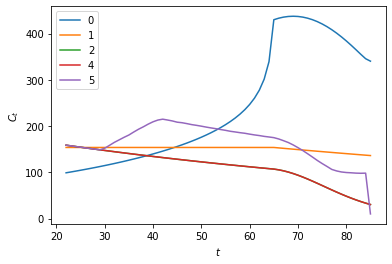

In [37]:
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
ax.plot(t1, Cts0, label='0')
ax.plot(t1, Cts1, label='1')
ax.plot(t1, Cts2, label='2')
ax.plot(t1, Cts4, label='4')
ax.plot(t1, Cts5, label='5')
ax.set_xlabel('$t$')
ax.set_ylabel('$C_t$')
ax.legend()
plt.show()

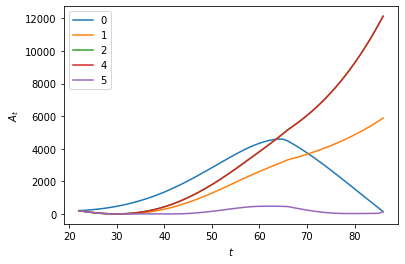

In [38]:
fig, ax = plt.subplots()
t1 = list(range(22, T + 2))
ax.plot(t1, Ats0, label='0')
ax.plot(t1, Ats1, label='1')
ax.plot(t1, Ats2, label='2')
ax.plot(t1, Ats4, label='4')
ax.plot(t1, Ats5, label='5')
ax.set_xlabel('$t$')
ax.set_ylabel('$A_t$')
ax.legend()
plt.show()

さてここからは単純に図4-1a から図4-10b まで「検算」して図示していこう。

In [39]:
Yts = y[22:R+1] + [z] * (T - R)

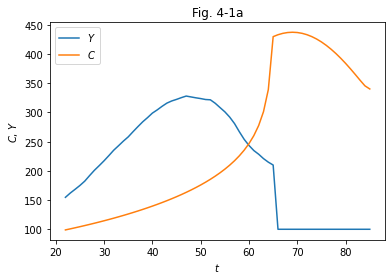

In [40]:
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
ax.plot(t1, Yts, label='$Y$')
ax.plot(t1, Cts0, label='$C$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$, $Y$')
ax.set_title('Fig. 4-1a')
ax.legend()
plt.show()

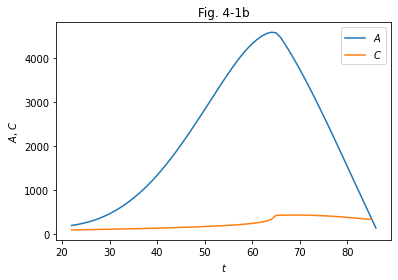

In [41]:
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
t2 = list(range(22, T + 2))
ax.plot(t2, Ats0, label='$A$')
ax.plot(t1, Cts0, label='$C$')
ax.set_xlabel('$t$')
ax.set_ylabel('$A$, $C$')
ax.set_title('Fig. 4-1b')
ax.legend()
plt.show()

In [42]:
reset_to_standard()
set_alternative('r')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

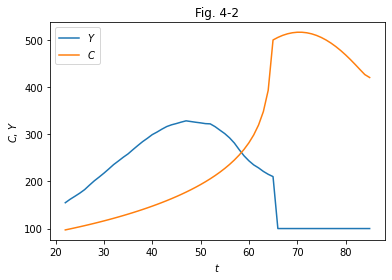

In [43]:
Cts1, Ats1, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
ax.plot(t1, Yts, label='$Y$')
ax.plot(t1, Cts1, label='$C$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$, $Y$')
ax.set_title('Fig. 4-2')
ax.legend()
plt.show()

In [44]:
reset_to_standard()
set_alternative('tau')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

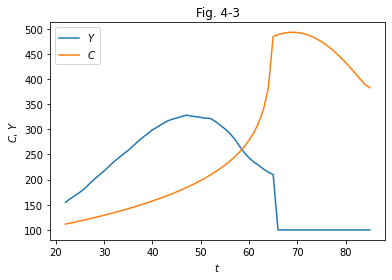

In [45]:
Cts1, Ats1, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
ax.plot(t1, Yts, label='$Y$')
ax.plot(t1, Cts1, label='$C$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$, $Y$')
ax.set_title('Fig. 4-3')
ax.legend()
plt.show()

In [46]:
reset_to_standard()
set_alternative('theta')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

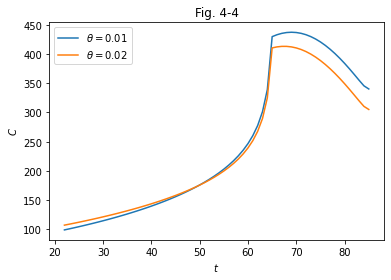

In [47]:
Cts1, Ats1, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
ax.plot(t1, Cts0, label='$θ = 0.01$')
ax.plot(t1, Cts1, label='$θ = 0.02$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$')
ax.set_title('Fig. 4-4')
ax.legend()
plt.show()

In [48]:
reset_to_standard()
set_alternative('F65')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

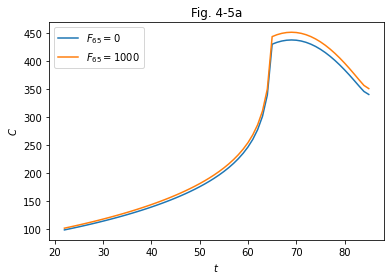

In [49]:
Cts1, Ats1, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
ax.plot(t1, Cts0, label='$F_{65} = 0$')
ax.plot(t1, Cts1, label='$F_{65} = 1000$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$')
ax.set_title('Fig. 4-5a')
ax.legend()
plt.show()

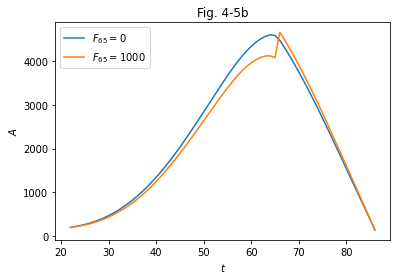

In [50]:
fig, ax = plt.subplots()
t1 = list(range(22, T + 2))
ax.plot(t1, Ats0, label='$F_{65} = 0$')
ax.plot(t1, Ats1, label='$F_{65} = 1000$')
ax.set_xlabel('$t$')
ax.set_ylabel('$A$')
ax.set_title('Fig. 4-5b')
ax.legend()
plt.show()

In [51]:
reset_to_standard()
set_alternative('z')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

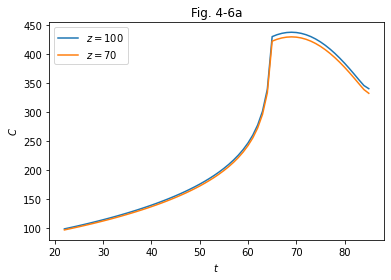

In [52]:
Cts1, Ats1, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, T + 1))
ax.plot(t1, Cts0, label='$z = 100$')
ax.plot(t1, Cts1, label='$z = 70$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$')
ax.set_title('Fig. 4-6a')
ax.legend()
plt.show()

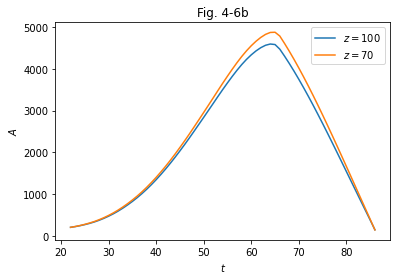

In [53]:
fig, ax = plt.subplots()
t1 = list(range(22, T + 2))
ax.plot(t1, Ats0, label='$z = 100$')
ax.plot(t1, Ats1, label='$z = 70$')
ax.set_xlabel('$t$')
ax.set_ylabel('$A$')
ax.set_title('Fig. 4-6b')
ax.legend()
plt.show()

In [54]:
reset_to_standard()
set_case_II()
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

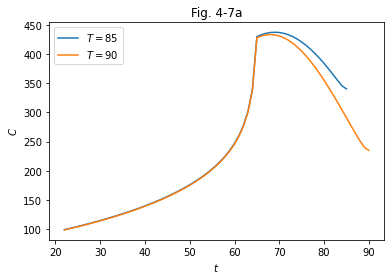

In [55]:
Cts1, Ats1, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, case_I['T'] + 1))
t2 = list(range(22, case_II['T'] + 1))
ax.plot(t1, Cts0, label='$T = 85$')
ax.plot(t2, Cts1, label='$T = 90$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$')
ax.set_title('Fig. 4-7a')
ax.legend()
plt.show()

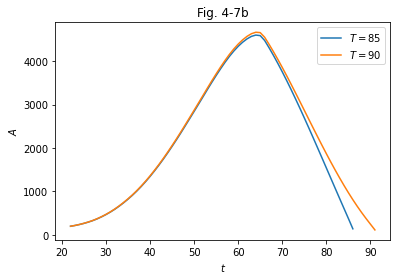

In [56]:
fig, ax = plt.subplots()
t1 = list(range(22, case_I['T'] + 2))
t2 = list(range(22, case_II['T'] + 2))
ax.plot(t1, Ats0, label='$T = 85$')
ax.plot(t2, Ats1, label='$T = 90$')
ax.set_xlabel('$t$')
ax.set_ylabel('$A$')
ax.set_title('Fig. 4-7b')
ax.legend()
plt.show()

In [57]:
reset_to_standard()
set_case_II()
set_alternative('gamma')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

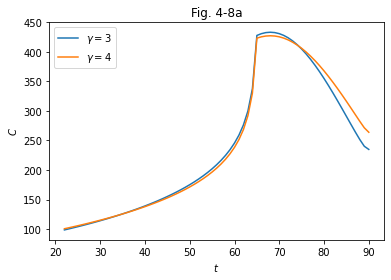

In [58]:
Cts2, Ats2, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, case_II['T'] + 1))
ax.plot(t1, Cts1, label='$γ = 3$')
ax.plot(t1, Cts2, label='$γ = 4$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$')
ax.set_title('Fig. 4-8a')
ax.legend()
plt.show()

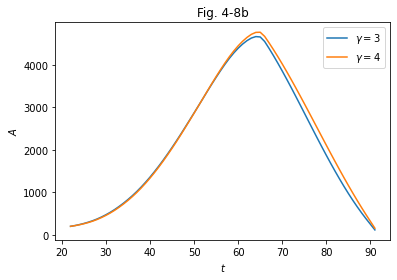

In [59]:
fig, ax = plt.subplots()
t1 = list(range(22, case_II['T'] + 2))
ax.plot(t1, Ats1, label='$γ = 3$')
ax.plot(t2, Ats2, label='$γ = 4$')
ax.set_xlabel('$t$')
ax.set_ylabel('$A$')
ax.set_title('Fig. 4-8b')
ax.legend()
plt.show()

In [60]:
reset_to_standard()
set_case_II()
set_alternative('k')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

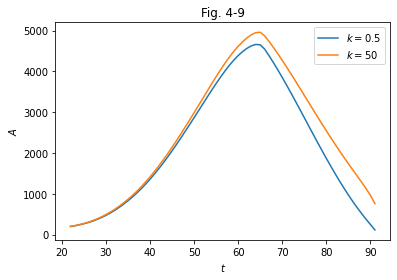

In [61]:
Cts2, Ats2, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, case_II['T'] + 2))
ax.plot(t1, Ats1, label='$k = 0.5$')
ax.plot(t2, Ats2, label='$k = 50$')
ax.set_xlabel('$t$')
ax.set_ylabel('$A$')
ax.set_title('Fig. 4-9')
ax.legend()
plt.show()

In [62]:
reset_to_standard()
set_case_II()
set_alternative('A22')
set_params()

sol = scipy.optimize.root(score_A_Tp1, A22)
sol.success

True

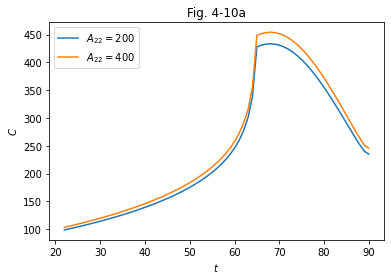

In [63]:
Cts2, Ats2, _ = get_Cts_Ats(sol.x)
fig, ax = plt.subplots()
t1 = list(range(22, case_II['T'] + 1))
ax.plot(t1, Cts1, label='$A_{22} = 200$')
ax.plot(t1, Cts2, label='$A_{22} = 400$')
ax.set_xlabel('$t$')
ax.set_ylabel('$C$')
ax.set_title('Fig. 4-10a')
ax.legend()
plt.show()

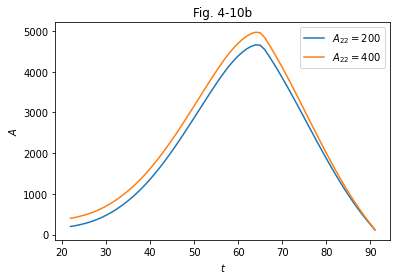

In [64]:
fig, ax = plt.subplots()
t1 = list(range(22, case_II['T'] + 2))
ax.plot(t1, Ats1, label='$A_{22} = 200$')
ax.plot(t2, Ats2, label='$A_{22} = 400$')
ax.set_xlabel('$t$')
ax.set_ylabel('$A$')
ax.set_title('Fig. 4-10b')
ax.legend()
plt.show()

ちゃんと「検算」できてるように思う。